# Readout Dynamics of 4PFs with quantum jump method

In [1]:
import numpy as np
from numpy.linalg import eig
import scipy.linalg as sla
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['text.usetex']=True
plt.rcParams['font.size']=26

In [74]:
# Definition of constants
phiL = np.arctan(1/np.sqrt(27)) ### Phase of the left PF coupling
phiR = np.pi/14 ### Phase of the right PF coupling
d = np.pi/15 ### Phase of the middle PF coupling

lam = 2.4e3*2*np.pi ### Angular frequency measure in units of 1/{\mu}s
epsL_ini = 50*lam ### Left PF overlap energy at t<0
epsL_quench = 1e-4*50*lam ### Left PF overlap energy at t>0
epsR_ini = 45*lam ### Right PF overlap energy at t<0
epsR_quench = 1e-4*45*lam ### Right PF overlap energy at t>0
epsLR = 1e-4*5*lam ### Cross capacitance term
EJ_ini = lam ### Middle PF overlap energy at t<0
EJ_quench = lam ### Middle PF overlap energy at t>0

Gam = lam/10  ### Measurement rate between lead and PF 2 
beta = (3/lam) ### Inverse temperature
Vfix= 2.6*lam ### Fixed voltage

dt =1e-4 ### Time step in units of {\mu}s
tres =1e-2 ### Resolution time in units of {\mu}s
tb = 1e-1 ### The integration time in units of {\mu}s (t_avg in article) 
Nlong=round(tres/dt)*200 ### Number of time steps
Navg=round(tb/dt) ### The number time steps averaged over for finding the current
Nsample=50 ### Option for sampling more than one trajectory of the quantum jump evolution. In the paper, this is set to 10^4

In [31]:
### The states below are expressed in the basis (|Q,q_L>, |Q+3,q_L>)
q0 = np.array([1.,0,0,0,0,0,0,0,0,0,0,0], dtype=complex) ### Eigenstate of P_L with q_L=0
s0 = np.array([1./np.sqrt(6),1./np.sqrt(6),1./np.sqrt(6),1./np.sqrt(6),1./np.sqrt(6),1./np.sqrt(6),0,0,0,0,0,0], dtype=complex) ### Eigenstate of P_J with j=0 
s1 = np.array([1./np.sqrt(6),np.exp(-1j*np.pi/3)/np.sqrt(6),np.exp(-1j*np.pi*2/3)/np.sqrt(6),np.exp(-1j*np.pi)/np.sqrt(6),np.exp(-1j*np.pi*4/3)/np.sqrt(6),np.exp(-1j*np.pi*5/3)/np.sqrt(6),0,0,0,0,0,0], dtype=complex) ### Eigenstate of P_J with j=1 
s2 = np.array([1./np.sqrt(6),np.exp(-1j*np.pi*2/3)/np.sqrt(6),np.exp(-1j*np.pi*4/3)/np.sqrt(6),np.exp(-1j*np.pi*2)/np.sqrt(6),np.exp(-1j*np.pi*8/3)/np.sqrt(6),np.exp(-1j*np.pi*10/3)/np.sqrt(6),0,0,0,0,0,0], dtype=complex) ### Eigenstate of P_J with j=2 

In [32]:
el05=np.zeros((12,12))
el05[0,5]=1
el05[6,11]=1
el50=np.zeros((12,12))
el50[5,0]=1
el50[11,6]=1

In [33]:
HL_ini = -2*epsL_ini*np.diag([np.cos(phiL),np.cos(np.pi/3+phiL),np.cos(np.pi*2/3+phiL),np.cos(np.pi+phiL),np.cos(np.pi*4/3+phiL),np.cos(np.pi*5/3+phiL),np.cos(phiL),np.cos(np.pi/3+phiL),np.cos(np.pi*2/3+phiL),np.cos(np.pi+phiL),np.cos(np.pi*4/3+phiL),np.cos(np.pi*5/3+phiL)],0)

def HR_ini(Q):
    return -2*epsR_ini*np.diag([np.cos(np.pi*Q/3+phiR),np.cos(np.pi*(Q-1)/3+phiR),np.cos(np.pi*(Q-2)/3+phiR),np.cos(np.pi*(Q-3)/3+phiR),np.cos(np.pi*(Q-4)/3+phiR),np.cos(np.pi*(Q-5)/3+phiR),np.cos(np.pi*(Q+3)/3+phiR),np.cos(np.pi*(Q+3-1)/3+phiR),np.cos(np.pi*(Q+3-2)/3+phiR),np.cos(np.pi*(Q+3-3)/3+phiR),np.cos(np.pi*(Q+3-4)/3+phiR),np.cos(np.pi*(Q+3-5)/3+phiR)],0)

def HLR(Q):
    return -2*epsLR*np.diag([np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR)],0)

HJ_ini = -EJ_ini*np.diag([np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),0,np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d)],1)-EJ_ini*np.diag([np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),0,np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),np.exp(1j*d)],-1)-EJ_ini*np.exp(-1j*d)*el50-EJ_ini*np.exp(1j*d)*el05

In [34]:
def Hblock_ini(Q): ### The 4PF Hamiltonian with pre-quench parameters 
    return HL_ini+HR_ini(Q)+HLR(Q)+HJ_ini

In [35]:
eval0_ini,estat0_ini=eig(Hblock_ini(0))
idx0 = eval0_ini.argsort()
GS03 = estat0_ini[:,idx0[0]]

eval1_ini,estat1_ini=eig(Hblock_ini(1))
eval2_ini,estat2_ini=eig(Hblock_ini(2))

In [36]:
GS03

array([9.99884332e-01+0.00000000e+00j, 1.06295101e-02+2.25937211e-03j,
       3.57165517e-05+1.59016505e-05j, 1.67745960e-07+1.70811187e-09j,
       3.47292408e-05-1.54620632e-05j, 1.04083681e-02-2.21236693e-03j,
       0.00000000e+00-0.00000000e+00j, 0.00000000e+00-0.00000000e+00j,
       0.00000000e+00-0.00000000e+00j, 0.00000000e+00-0.00000000e+00j,
       0.00000000e+00-0.00000000e+00j, 0.00000000e+00-0.00000000e+00j])

In [37]:
evals_ini=np.concatenate((np.concatenate((eval0_ini,eval1_ini)),eval2_ini))
x=[1]*len(evals_ini)
Qcolour=['tab:blue']*12+['tab:orange']*12+['tab:green']*12

C:\Users\Ida Nielsen\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


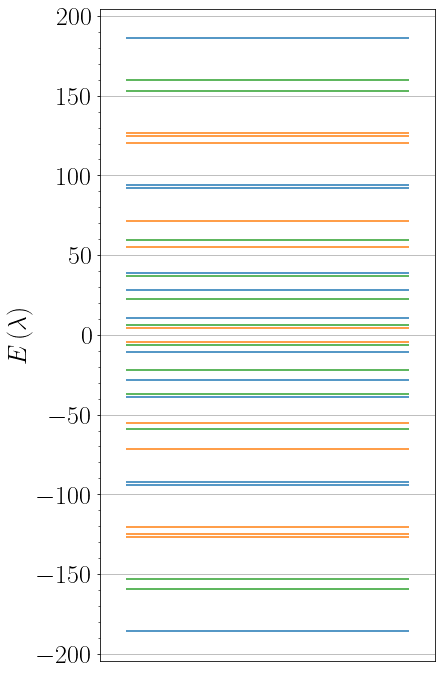

In [38]:
fig, ax =plt.subplots(figsize=(6, 12)) ### Spectrum before the quench
ax.set_ylabel(r'$E\, (\lambda)$')
ax.scatter(x, evals_ini/lam,s=80000,  marker="_", c=Qcolour,linewidth=1.5)
ax.grid(axis='y')
ax.set_xticks([])
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(50))

In [39]:
HL_quench = -2*epsL_quench*np.diag([np.cos(phiL),np.cos(np.pi/3+phiL),np.cos(np.pi*2/3+phiL),np.cos(np.pi+phiL),np.cos(np.pi*4/3+phiL),np.cos(np.pi*5/3+phiL),np.cos(phiL),np.cos(np.pi/3+phiL),np.cos(np.pi*2/3+phiL),np.cos(np.pi+phiL),np.cos(np.pi*4/3+phiL),np.cos(np.pi*5/3+phiL)],0)

def HR_quench(Q):
    return -2*epsR_quench*np.diag([np.cos(np.pi*Q/3+phiR),np.cos(np.pi*(Q-1)/3+phiR),np.cos(np.pi*(Q-2)/3+phiR),np.cos(np.pi*(Q-3)/3+phiR),np.cos(np.pi*(Q-4)/3+phiR),np.cos(np.pi*(Q-5)/3+phiR),np.cos(np.pi*(Q+3)/3+phiR),np.cos(np.pi*(Q+3-1)/3+phiR),np.cos(np.pi*(Q+3-2)/3+phiR),np.cos(np.pi*(Q+3-3)/3+phiR),np.cos(np.pi*(Q+3-4)/3+phiR),np.cos(np.pi*(Q+3-5)/3+phiR)],0)

def HLR(Q):
    return -2*epsLR*np.diag([np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*Q/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR),np.cos(np.pi*(Q+3)/3+phiL+phiR)],0)

HJ_quench = -EJ_quench*np.diag([np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),0,np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d),np.exp(-1j*d)],1)-EJ_quench*np.diag([np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),0,np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),np.exp(1j*d),np.exp(1j*d)],-1)-EJ_quench*np.exp(-1j*d)*el50-EJ_quench*np.exp(1j*d)*el05

In [40]:
def Hblock_quench(Q): ### The 4PF Hamiltonian with post-quench parameters 
    return HL_quench+HR_quench(Q)+HLR(Q)+HJ_quench

In [41]:
eval0_quench,estat0_quench=sla.eig(Hblock_quench(0))

eval1_quench,estat1_quench=sla.eig(Hblock_quench(1))

eval2_quench,estat2_quench=sla.eig(Hblock_quench(2))

In [42]:
evals_quench=np.concatenate((np.concatenate((eval0_quench,eval1_quench)),eval2_quench))
x=[1]*len(evals_quench)
Qcolour=['skyblue']*12+['sandybrown']*12+['lightgreen']*12

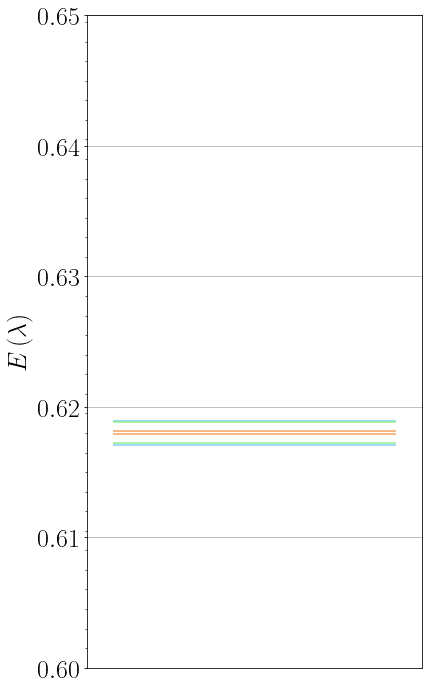

In [43]:
fig, ax =plt.subplots(figsize=(6, 12)) ### Zoom in at spectrum after the quench
ax.set_ylabel(r'$E\, (\lambda)$')
ax.scatter(x, evals_quench/lam,s=80000,  marker="_", c=Qcolour,linewidth=1.5)
ax.grid(axis='y')
ax.set_xticks([])
plt.ylim(ymin=0.6,ymax=0.65) ### Remove this line to see full spectrum
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(50))

In [44]:
tau3=np.diag([1,-1,1,-1,1,-1,1,-1,1,-1,1,-1],0)
sig3=np.hstack((np.hstack((np.concatenate((np.zeros((9,3)),np.identity(3))),np.vstack((np.concatenate((np.zeros((6,3)),np.identity(3))),np.zeros((3,3)))))),np.hstack((np.vstack((np.concatenate((np.zeros((3,3)),np.identity(3))),np.zeros((6,3)))),np.concatenate((np.identity(3),np.zeros((9,3))))))))
t3s3=tau3@sig3

In [45]:
Lin_03= np.zeros((12,12), dtype=complex) ### The L+ jump operator in the Q=0,3 subspace
for m in range(12):
    for n in range(12):
        Lin_03 = Lin_03 + np.sqrt(Gam)*np.sqrt(1/(1+np.exp(beta*(eval0_quench[m]-eval0_quench[n]-Vfix))))*np.vdot(estat0_quench[:,m],(t3s3.dot(estat0_quench[:,n])))*np.outer(estat0_quench[:,m],(estat0_quench[:,n].conj()))

In [46]:
Lout_03= np.zeros((12,12), dtype=complex) ### The L- jump operator in the Q=0,3 subspace
for m in range(12):
    for n in range(12):
        Lout_03 = Lout_03 + np.sqrt(Gam)*np.sqrt(1-1/(1+np.exp(beta*(eval0_quench[n]-eval0_quench[m]-Vfix))))*np.vdot(estat0_quench[:,m],(t3s3.dot(estat0_quench[:,n])))*np.outer(estat0_quench[:,m],(estat0_quench[:,n].conj()))

In [47]:
U03 = sla.expm(-1j*dt*(Hblock_quench(0)-1j*((Lin_03.T.conj())@Lin_03+(Lout_03.T.conj())@Lout_03)/2)) ### The no-jump evolution operator in the Q=0,3 subspace

In [75]:
Jtab=[]
for n in range(Nsample):
    st = GS03 ### Insert here the initial state
    Jdiff03=[]
    j1=0
    j2=0
    for i in range(1,Nlong+1):
        stnj = U03.dot(st)
        stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
        L1st = Lin_03.dot(stnjR)
        L2st = Lout_03.dot(stnjR)
        Pj1 = dt*(np.vdot(L1st,L1st)).real
        Pj2 = dt*(np.vdot(L2st,L2st)).real
        P=np.random.uniform()
        P1=np.random.uniform()
        P2=np.random.uniform()
        if P<0.5:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1+0
                    j2=j2+1
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2+0
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        Jdiff03.append(j1-j2)
    Jtab.append(Jdiff03)


Jarr03=np.array(Jtab)
Itab03=[]
for n in range(Nsample):
    I=[]
    for i in range(Navg, Nlong):
        curr=1e12*1.6e-19*(Jarr03[n,i]-Jarr03[n,i-Navg])/(tb*1e-6)
        I.append(curr)
    Itab03.append(I)
    
Iarr03=np.array(Itab03)

In [59]:
ttab=np.linspace(tb,Nlong*dt,Nlong-Navg)
s0mean=4.54
s1mean=236.9
s2mean=108.0

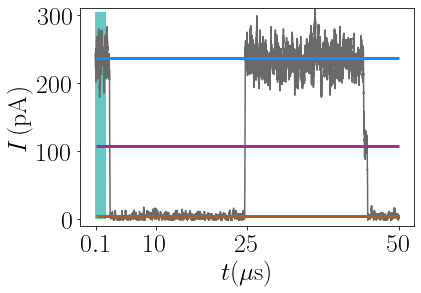

In [60]:
### Set Nsample=1 and Nlong=round(tres/dt)*5000 above to create this plot of the current trajectories over long times
fig, ax = plt.subplots()
ax.set_xlabel(r'$t(\mu {\rm s})$')
ax.set_ylabel(r'$I\, ({\rm pA})$')
ax.set_xticks(np.array([tb,1000*tres,2500*tres,5000*tres]), labels=['$0.1$','$10$','$25$','$50$'])
ax.set_yticks(np.array([0,100,200,300]))
plt.ylim(ymin=-10,ymax=310)
plt.plot(ttab,Iarr03[0],color='dimgrey')
ax.hlines(s0mean,tb,Nlong*dt,color='#b45c1f',linewidth=3)
ax.hlines(s1mean,tb,Nlong*dt,color='#0E8EFF',linewidth=3)
ax.hlines(s2mean,tb,Nlong*dt,color='#A02CA0',linewidth=3)
plt.bar(0.95,305,width=1.9,color='lightseagreen',alpha=0.7)
plt.show()

In [67]:
### For the histogram, set Nsample large (10^4 is used for the article) and Nlong=round(tres/dt)*200
mean03=[]
for n in range(Nsample):
    mean=np.mean(Iarr03[n])
    mean03.append(mean)

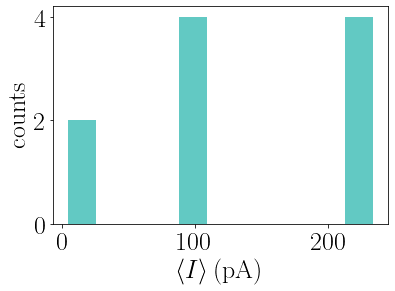

In [70]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\langle I\rangle\, ({\rm pA})$')
ax.set_ylabel(r'${\rm counts}$')
plt.hist(mean03,bins=11,color='lightseagreen',alpha=0.7)
plt.show()